In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

df = pd.read_excel('/content/drive/MyDrive/ktd231026/m5_ml/Online_Retail.xlsx', header=1)
print(df.shape)
df.info()

(541908, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541908 entries, 0 to 541907
Data columns (total 8 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   536365                              541908 non-null  object        
 1   85123A                              541908 non-null  object        
 2   WHITE HANGING HEART T-LIGHT HOLDER  540454 non-null  object        
 3   6                                   541908 non-null  int64         
 4   2010-12-01 08:26:00                 541908 non-null  datetime64[ns]
 5   2.55                                541908 non-null  float64       
 6   17850                               406828 non-null  float64       
 7   United Kingdom                      541908 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
# 컬럼명 변경
df.columns = ['주문번호', '상품코드', '거래 품목', '건수', '거래일시', '단가', '고객ID', '지역']

In [5]:
import numpy as np
import datetime
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df.head(3)

,주문번호,상품코드,거래 품목,건수,거래일시,단가,고객ID,지역
0,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
1,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
2,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
df.info

<bound method DataFrame.info of           주문번호    상품코드                                거래 품목  건수  \
0       536365   71053                  WHITE METAL LANTERN   6   
1       536365  84406B       CREAM CUPID HEARTS COAT HANGER   8   
2       536365  84029G  KNITTED UNION FLAG HOT WATER BOTTLE   6   
3       536365  84029E       RED WOOLLY HOTTIE WHITE HEART.   6   
4       536365   22752         SET 7 BABUSHKA NESTING BOXES   2   
...        ...     ...                                  ...  ..   
541903  581587   22613          PACK OF 20 SPACEBOY NAPKINS  12   
541904  581587   22899         CHILDREN'S APRON DOLLY GIRL    6   
541905  581587   23254        CHILDRENS CUTLERY DOLLY GIRL    4   
541906  581587   23255      CHILDRENS CUTLERY CIRCUS PARADE   4   
541907  581587   22138        BAKING SET 9 PIECE RETROSPOT    3   

                      거래일시    단가     고객ID              지역  
0      2010-12-01 08:26:00  3.39  17850.0  United Kingdom  
1      2010-12-01 08:26:00  2.75  17850.0  

In [7]:
# 데이터 필터링
df = df[df['건수']>0]
df = df[df['단가']>0]
df = df[df['고객ID'].notnull()]

#country 칼럼 데이터 필터링
df['지역'].value_counts()[:5]
df = df[df['지역']=='United Kingdom']
print(df.isnull().sum()) # 결측값 개수 확인
print(df.shape)

주문번호     0
상품코드     0
거래 품목    0
건수       0
거래일시     0
단가       0
고객ID     0
지역       0
dtype: int64
(354320, 8)


In [9]:
#RFM 기반 데이터 가공

#주문 금액 칼럼 생성, CustomerID 형변환
df['sale_amount'] = df['건수'] * df['단가']
df['고객ID'] = df['고객ID'].astype(int)

#Customer ID 기준 TOP-5 주문 건수, 주문 금액 데이터 추출
print(df['고객ID'].value_counts().head(5))
print(df.groupby('고객ID')['sale_amount'].sum().sort_values(ascending=False).head(5))

#고유 식별자 확인
df.groupby(['주문번호', '상품코드'])['주문번호'].count().mean()

17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: 고객ID, dtype: int64
고객ID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


1.0287021606461615

In [15]:
#DataFrame의 groupby()의 multiple 연산을 위해 agg()을 이용
#Recency는 InvoiceDate 칼럼의 max()에서 데이터 가공
#Frequency는 InvoiceDate 칼럼의 count(), Monetary value 는 sale_amount 칼럼의 sum()
aggregations = {
    '거래일시':'max',
    '주문번호':'count',
    'sale_amount':'sum'
}
cust_df = df.groupby('고객ID').agg(aggregations)

#groupby된 결과 칼럼 값을 Recency, Frequency, Monetary로 변경
cust_df = cust_df.rename(columns = {'거래일시':'Recency',
                                   '주문번호':'Frequency',
                                   'sale_amount':'Monetary'
                                   }
                        )
cust_df = cust_df.reset_index()
cust_df.head(3)

,고객ID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


In [16]:
import numpy as np

cust_df['Recency'] = datetime.datetime(2011, 12, 10) - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x : x.days+1)
print('cust_df 로우와 칼럼의 개수는', cust_df.shape)
cust_df

cust_df 로우와 칼럼의 개수는 (3920, 4)


,고객ID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73
3,12749,4,199,4090.88
4,12820,4,59,942.34
...,...,...,...,...
3915,18280,278,10,180.60
3916,18281,181,7,80.82
3917,18282,8,12,178.05
3918,18283,4,756,2094.88


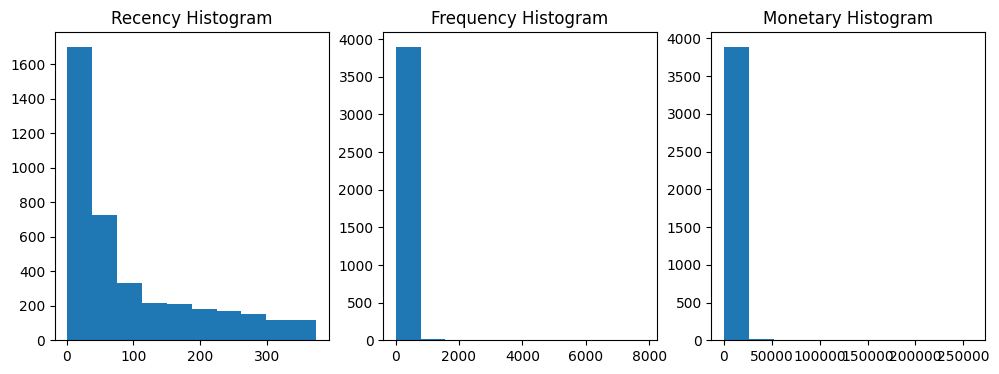

In [17]:
#hist()를 이용하여 각 칼럼의 값 분포도 확인
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])

plt.show()

### RFM 기반 고객 세그먼테이션
- 온라인 판매 데이터는 소매업체의 대규모 주문이 포함되어있어 주문 횟수와 주문 금액에서 개인 고객 주문과 매우 큰 차이를 나타냄. 이로 인해 왜곡된 데이터 분포도를 가짐
- 맥플롯립의 hist()를 통해 각 칼럼의 값 분포도를 확인하면 모두 왜곡된 데이터 값 분포도를 가지고 있음을 확인할 수 있음
- describe()를 통해 각 칼럼의 데이터 값 백분위로 어떻게 값이 분포되어 있는지 확인
  - Recency는 평균이 92.7이지만, 50%인 51보다 크게 높음, max 는 374로 75%인 143보다 훨씬 커 왜곡 정도가 심함
  - Frequency의 경우 평균이 90.3이지만 max 값 7847를 포함한 상위의 몇 개의 큰 값으로 인해 75%가 99.25에 가까움
  - Monetary도 마찬가지로 상위의 큰 값으로 인해 평균은 1864.3으로 75%인 1576.5보다 높은 값이 확인 됨

- 왜곡 정도가 매우 높은 데이터 세트에 K-평균을 적용하면 중심의 개수를 증가시키더라도 변별력이 떨어지는 군집화가 수행되기 때문에 StandScaler로 평균과 표준편차를 재조정
- 군집을 3개로 구성할 경우 전체 군집의 평균 실루엣 계수는 0.576

In [18]:
#백분위 값으로 데이터 분포도 확인
cust_df[['Recency', 'Frequency', 'Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.387755,1864.381697
std,99.533485,217.808144,7482.815641
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


In [19]:
#StandScaler로 평균과 표준편차 재조정
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features = cust_df[['Recency', 'Frequency', 'Monetary']]#.values
X_features_scaled = StandardScaler().fit_transform(X_features) # 왜 df 그대로 안하고 ndarray로 바꿔서 스케일링하는거지?

#K-평균 수행
kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


실루엣 스코어는 : 0.592


In [20]:
# 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features):

    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
        clusterer = KMeans(n_clusters = n_cluster, n_init='auto', max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현.
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [21]:
# 군집 개수별로 군집화 구성을 시각화하는 사용자 함수
def visualize_kmeans_plot_multi(cluster_lists, X_features):

    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import warnings
    warnings.filterwarnings('ignore')

    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])

     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장.
        clusterer = KMeans(n_clusters = n_cluster, n_init='auto', max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels

        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']

        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70, edgecolor='k', marker=markers[label], label=cluster_legend)
            # axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70, marker='o', edgecolor='k', facecolor='none')

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))
        axs[ind].legend(loc='upper right')

    plt.show()

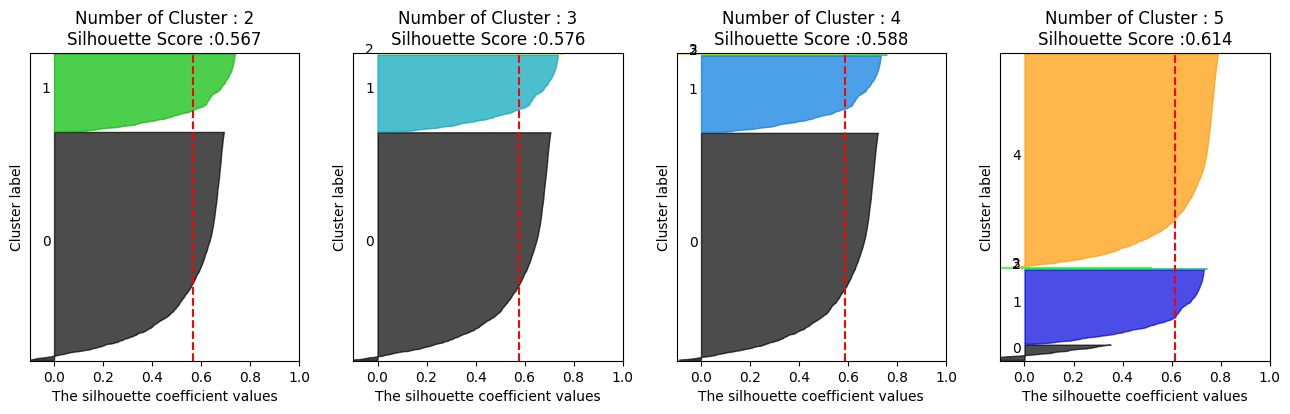

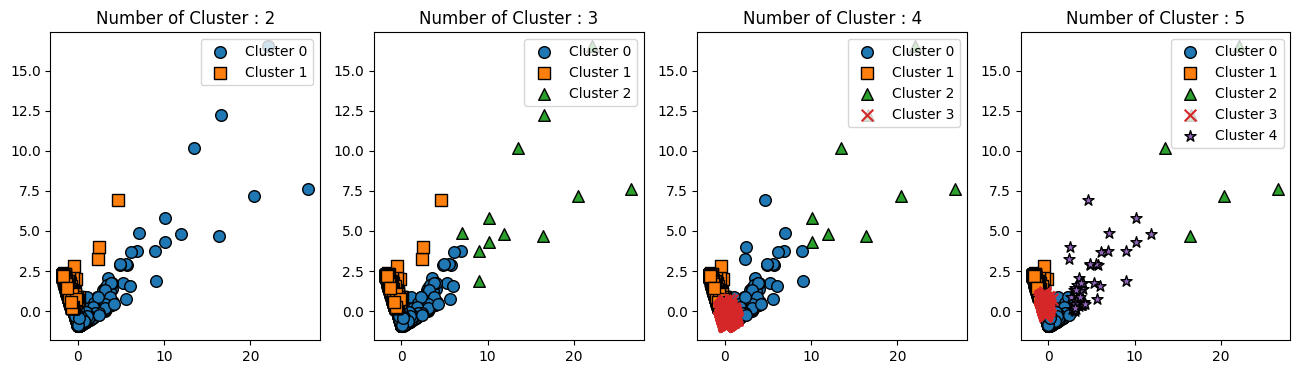

In [22]:
# 각 군집별 실루엣 계수 값 확인을 위해 군집 개수를 2~5개까지 변화시켜가며 군집화 구성 시각화
visualize_silhouette([2,3,4,5], X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)

- 군집 개수를 2~5개까지 변화시키면서 각 군집별 평균 실루엣 계수를 생성하여 확인
  - 군집이 2개일 때는 너무 개괄적으로 군집화, 3~5개일 때는 소수의 데이터 세트의 실루엣 계수가 매우 작은 것이 확인됨. 이는 특정 소매점의 대량 주문 구매 데이터로 해석할 수 있음
- 이처럼 지나치게 왜곡된 데이터 세트는 K-평균과 같은 거리 기반 군집화 알고리즘에서 지나치게 일반적인 군집화 결과를 도출하게 됨

In [26]:
#데이터의 왜곡 정도를 낮추기 위해 로그 변환
#Recency, Frequency, Monetary 칼럼에 np.log1p()로 Log Transformation
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

#Log Transformation 데이터에 StandScaler 적용
X_features = cust_df[['Recency_log', 'Frequency_log', 'Monetary_log']]#.values
X_features_scaled = StandardScaler().fit_transform(X_features)

#K-평균 수행
kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))


실루엣 스코어는 : 0.303


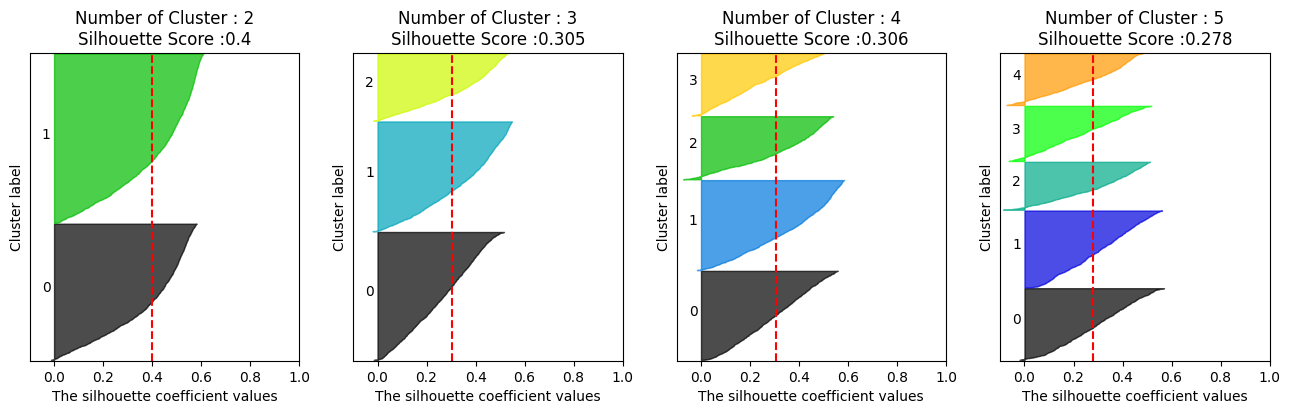

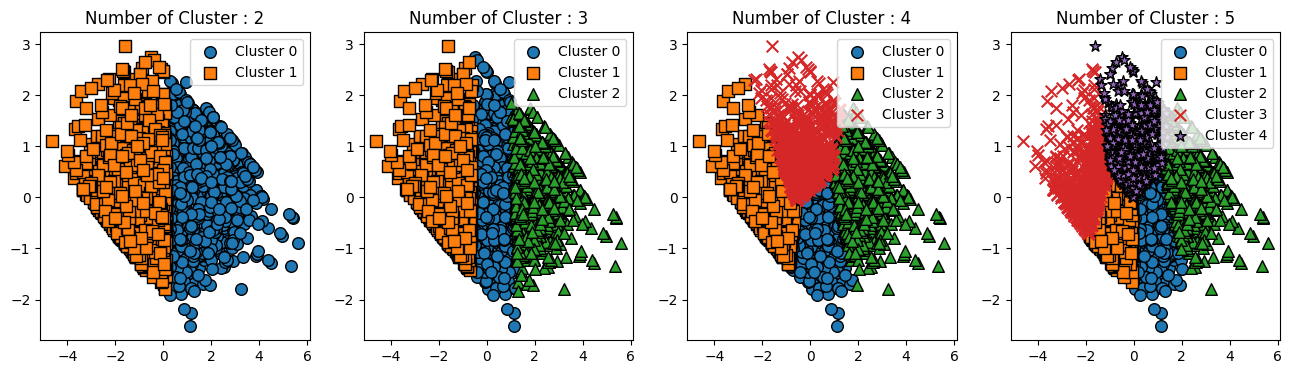

In [27]:
# 각 군집별 실루엣 계수 값 확인을 위해 군집 개수를 2~5개까지 변화시켜가며 군집화 구성 시각화
visualize_silhouette([2,3,4,5], X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)

- 비지도학습의 군집화의 기능적 의미는 숨어있는 새로운 집단을 발견하는 것. 새로운 군집 내의 데이터 값을 분석하고 이해함으로써 이 집단에 새로운 의미를 부여할 수 있음
- 데이터 세트의 왜곡정도를 낮추기 위해 로그변환 이용
- 실루엣 스코어는 로그 변환 하기 전보다 떨어지지만 더 균일하게 군집화가 구성됐음을 확인할 수 있음